In [2]:
!pip install imblearn

In [238]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from textblob import Word
nltk.download("wordnet")
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

import sklearn
from sklearn import model_selection
from sklearn import metrics
import sklearn.metrics as mt
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Zehra\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [301]:
df_test =  pd.read_csv("C:/Users/Zehra/Desktop/Python/Twitter_Sentiment/test.csv", error_bad_lines=False)
df_train =  pd.read_csv("C:/Users/Zehra/Desktop/Python/Twitter_Sentiment/train.csv", error_bad_lines=False)
df_submission =  pd.read_csv("C:/Users/Zehra/Desktop/Python/Twitter_Sentiment/sample_submission.csv", error_bad_lines=False)

In [302]:
df_train.isnull().sum()

id       0
label    0
tweet    0
dtype: int64

In [303]:
df=pd.concat([df_test, df_train], axis=0)

In [304]:
df=df.drop("id", axis=1)

In [305]:
df

,tweet,label
0,#studiolife #aislife #requires #passion #dedic...,NaN
1,@user #white #supremacists want everyone to s...,NaN
2,safe ways to heal your #acne!! #altwaystohe...,NaN
3,is the hp and the cursed child book up for res...,NaN
4,"3rd #bihday to my amazing, hilarious #nephew...",NaN
...,...,...
31957,ate @user isz that youuu?ðððððð...,0.0
31958,to see nina turner on the airwaves trying to...,0.0
31959,listening to sad songs on a monday morning otw...,0.0
31960,"@user #sikh #temple vandalised in in #calgary,...",1.0


In [306]:
df.shape

(49159, 2)

C:\Users\Zehra\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


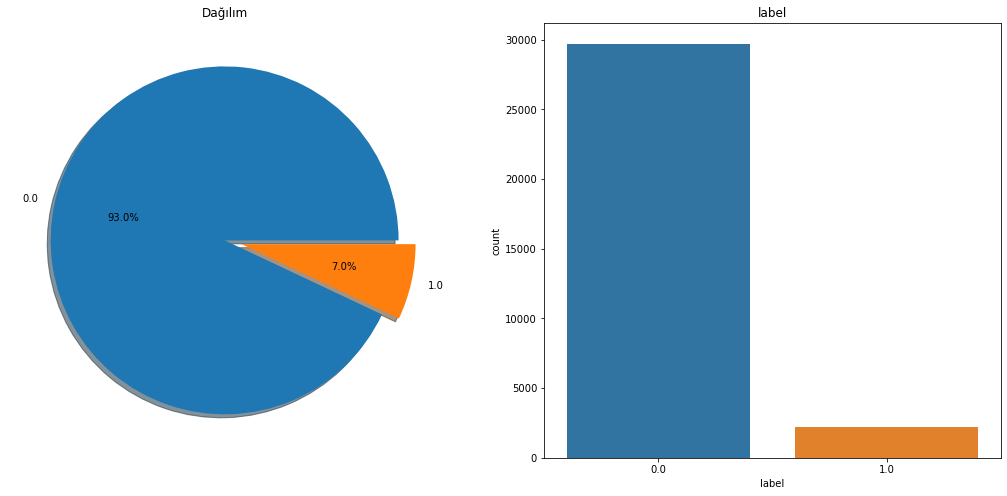

In [307]:
f,ax=plt.subplots(1,2,figsize=(18,8))
df['label'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Dağılım')
ax[0].set_ylabel('')
sns.countplot('label',data=df,ax=ax[1])
ax[1].set_title('label')
plt.show()

### Veri Temizleme

In [308]:
def CleanTxt(text):
    text=re.sub(r'@[A-Za-z0-9]+', '', text)
    text=re.sub(r'#', ' ', text) # hashtag silmek için
    text=re.sub(r'RT[\s]+', '', text) #rt
    text=re.sub(r'https?:\/\/\S+', '', text)  #web siteleri için
    text=re.sub(r"\b[a-zA-Z]\b", "", text)
    text=re.sub("\d","", text)
    text=re.sub("[^A-Za-z]"," ", text)
    return text
    
df["tweet"]=df["tweet"].apply(CleanTxt)

In [309]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

df["tweet"]=df["tweet"].apply(remove_emoji)

In [310]:
pd.Series(" ".join(df["tweet"]).split()).value_counts()

the                      15751
to                       15108
you                       9054
and                       7672
in                        7065
                         ...  
rrockalldayer                1
shakeshack                   1
weneedgodmorethanever        1
unpaused                     1
prop                         1
Length: 49046, dtype: int64

In [311]:
sw=stopwords.words("english")
df["tweet"] = df["tweet"].apply(lambda x: " ".join(x for x in x.split() if x not in sw))

In [312]:
df["tweet"] = df["tweet"].apply(lambda x: " ".join(Word(word).lemmatize() for word in x.split()))

In [313]:
df.head()

,tweet,label
0,studiolife aislife requires passion dedication...,NaN
1,white supremacist want everyone see new bird m...,NaN
2,safe way heal acne altwaystoheal healthy healing,NaN
3,hp cursed child book reservation already yes h...,NaN
4,rd bihday amazing hilarious nephew eli ahmir u...,NaN


In [314]:
pd.Series(" ".join(df["tweet"]).split()).value_counts()

love               4437
day                4416
amp                2709
happy              2654
time               1948
                   ... 
twilightsparkle       1
unironic              1
colorsay              1
payslip               1
ratm                  1
Length: 46093, dtype: int64

In [315]:
sil = pd.Series(' '.join(df['tweet']).split()).value_counts()[-42000:]
df['tweet'] = df['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in sil))

In [316]:
pd.Series(" ".join(df["tweet"]).split()).value_counts()

love             4437
day              4416
amp              2709
happy            2654
time             1948
                 ... 
doin               11
doc                11
sparkle            11
sorrynotsorry      11
giggle             11
Length: 4093, dtype: int64

# Makine Öğrenmesi

In [317]:
test=df[:df_train.shape[0]]
train=df[df_train.shape[0]:]

In [318]:
target = train[["label"]]

In [319]:
y=df[17197:].label

In [320]:
del df["label"]

In [321]:
x=df[17197:]

In [322]:
x_train, x_test, y_train, y_test = train_test_split(train["tweet"],target["label"] , random_state = 1)

In [323]:
vectorizer = TfidfVectorizer()
vectorizer.fit_transform(x_train)

<12897x4052 sparse matrix of type '<class 'numpy.float64'>'
	with 73610 stored elements in Compressed Sparse Row format>

In [324]:
x_train_vectorizer = vectorizer.transform(x_train)
x_test_vectorizer = vectorizer.transform(x_test)

In [325]:
test = test["tweet"]
test_tf_idf = vectorizer.transform(test)

### Decision Tree Classifier

In [326]:
model = DecisionTreeClassifier()

In [327]:
model = model.fit(x_train_vectorizer,y_train)

In [328]:
y_pred = model.predict(x_test_vectorizer)

In [329]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.3f"%(accuracy))

Accuracy: 0.939


Skorun 0.93 olması modelin başarısından değil, veri setinin dengesiz olmasından kaynaklanıyor.

Dengesiz veri setleriyle çalışırken doğru gözlem yapabilmek için uygulayabileceğimiz çeşitli yöntemler vardır.

- Doğru Metrik Seçimi

Precision

Recall

F1-score

ROC Curve

AUC

- Resampling

Oversampling

Undersampling

- Daha fazla veri toplamak


- Sınıflandırma modellerinde bulunan “class_weight” parametresi kullanılarak azınlık ve çoğunluk sınıflarından eşit şekilde öğrenebilen model yaratılması


- Tek bir modele değil , diğer modellerdeki performanslara da bakılması


- Daha farklı bir yaklaşım uygulanıp Anomaly detection veya Change detection yapmak

# Metrik Seçimi

### Precision

In [337]:
precision =(mt.precision_score(y_test, y_pred))

In [338]:
precision

0.6484375

### Recall

In [339]:
recall= mt.recall_score(y_test, y_pred)

In [340]:
recall

0.4896755162241888

### F1 Score

In [341]:
f1=2*((precision*recall)/(precision+recall))
print(f1)

0.5579831932773109


# Resampling

### Random Oversampling

In [343]:
y_train.value_counts()

0.0    12022
1.0      875
Name: label, dtype: int64

In [344]:
oversample = RandomOverSampler(sampling_strategy='minority')
x_randomover, y_randomover = oversample.fit_resample(x_train_vectorizer,y_train)

In [345]:
y_randomover.value_counts()

0.0    12022
1.0    12022
Name: label, dtype: int64

In [346]:
model.fit(x_randomover, y_randomover)

DecisionTreeClassifier()

In [347]:
y_pred = model.predict(x_test_vectorizer)

In [348]:
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.9155813953488372


In [349]:
precision =(mt.precision_score(y_test, y_pred))
print(precision)

0.4719626168224299


In [350]:
recall= mt.recall_score(y_test, y_pred)
print(recall)

0.5958702064896755


In [351]:
f1=2*((precision*recall)/(precision+recall))
print(f1)

0.5267275097783573


### Smote Oversampling

In [396]:
y_train.value_counts()

0.0    12022
1.0      875
Name: label, dtype: int64

In [397]:
oversample = SMOTE()
x_smote, y_smote = oversample.fit_resample(x_train_vectorizer, y_train)

In [398]:
y_smote.value_counts()

0.0    12022
1.0    12022
Name: label, dtype: int64

In [399]:
model.fit(x_smote, y_smote)

DecisionTreeClassifier()

In [400]:
y_pred = model.predict(x_test_vectorizer)

In [406]:
df2.reset_index(inplace=True)

In [407]:
df2=df2.drop("index", axis=1)

In [408]:
df3=pd.concat([df1, df2], axis=1)

In [409]:
df3[df3[0] == 1]

,0,tweet
18,1.0,affected son son abuse change sex ed via
25,1.0,hate youtuber giveaway like bother clearly goi...
31,1.0,going service able get day today philly
37,1.0,heard presidential debate isi putin lgbt right...
50,1.0,best poetry romantic poetry love poetry new po...
...,...,...
4282,1.0,fo woh pastor say officer act viral video arre...
4286,1.0,horny australian woman pussy
4288,1.0,awesome black man get kkk member blacklivesmatter
4292,1.0,trump movement


In [401]:
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.9176744186046512


In [402]:
precision =(mt.precision_score(y_test, y_pred))
print(precision)

0.48120300751879697


In [403]:
recall= mt.recall_score(y_test, y_pred)
print(recall)

0.5663716814159292


In [404]:
f1=2*((precision*recall)/(precision+recall))
print(f1)

0.5203252032520326


### Undersampling

In [373]:
y_train.value_counts()

0.0    12022
1.0      875
Name: label, dtype: int64

In [374]:
RanUS = RandomUnderSampler()
x_RanUS, y_RanUS = RanUS.fit_resample(x_train_vectorizer, y_train)

In [375]:
y_RanUS.value_counts()

0.0    875
1.0    875
Name: label, dtype: int64

In [376]:
model.fit(x_RanUS, y_RanUS)

DecisionTreeClassifier()

In [383]:
y_pred = model.predict(x_test_vectorizer)

In [384]:
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.8286046511627907


In [385]:
precision =(mt.precision_score(y_test, y_pred))
print(precision)

0.27640449438202247


In [386]:
recall= mt.recall_score(y_test, y_pred)
print(recall)

0.7256637168141593


In [387]:
f1=2*((precision*recall)/(precision+recall))
print(f1)

0.40032546786004874


### NearMiss Undersampling

Version 1

In [388]:
undersample = NearMiss(version=1, n_neighbors=6)

In [389]:
x_undersample, y_undersample = undersample.fit_resample(x_train_vectorizer, y_train)

In [390]:
model.fit(x_undersample, y_undersample)

DecisionTreeClassifier()

In [391]:
y_pred = model.predict(x_test_vectorizer)

In [392]:
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.7811627906976745


In [393]:
precision =(mt.precision_score(y_test, y_pred))
print(precision)

0.21973929236499068


In [394]:
recall= mt.recall_score(y_test, y_pred)
print(recall)

0.696165191740413


In [395]:
f1=2*((precision*recall)/(precision+recall))
print(f1)

0.3340410474168436


Version 2

In [111]:
undersample = NearMiss(version=2, n_neighbors=6)

In [112]:
x_undersample, y_undersample = undersample.fit_resample(x_train, y_train)

In [113]:
model.fit(x_undersample, y_undersample)

DecisionTreeClassifier()

In [114]:
y_pred = model.predict(x_test)

In [180]:
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.713215775502465


In [181]:
precision =(mt.precision_score(y_test, y_pred))
print(precision)

0.1509490810485086


In [182]:
recall= mt.recall_score(y_test, y_pred)
print(recall)

0.7076271186440678


In [183]:
f1=2*((precision*recall)/(precision+recall))
print(f1)

0.24882046188229454


Version 3

In [184]:
undersample = NearMiss(version=3, n_neighbors=3)

In [185]:
x_undersample, y_undersample = undersample.fit_resample(x_train, y_train)

C:\Users\Zehra\anaconda3\lib\site-packages\imblearn\under_sampling\_prototype_selection\_nearmiss.py:175: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(


In [186]:
model.fit(x_undersample, y_undersample)

DecisionTreeClassifier()

In [187]:
y_pred = model.predict(x_test)

In [188]:
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.6309252938945772


In [189]:
precision =(mt.precision_score(y_test, y_pred))
print(precision)

0.12643678160919541


In [190]:
recall= mt.recall_score(y_test, y_pred)
print(recall)

0.7612994350282486


In [191]:
f1=2*((precision*recall)/(precision+recall))
print(f1)

0.2168577750955542


In [410]:
s= np.array([["Decision Tree Classifier", 0.93,0.64,0.49,0.55], 
            ["Random Oversampling", 0.91,0.46,0.57,0.51], 
            ["Smote Oversampling",0.92,0.49,0.57,0.53], 
            ["Undersamling",0.82,0.27,0.72,0.40],
            ["NearMiss Undersampling",0.78,0.21,0.69,0.33]])

In [411]:
s=pd.DataFrame(s, columns=['Algoritma','Accuracy', 'Precision','Recall','F1_Score'])

In [412]:
s

,Algoritma,Accuracy,Precision,Recall,F1_Score
0,Decision Tree Classifier,0.93,0.64,0.49,0.55
1,Random Oversampling,0.91,0.46,0.57,0.51
2,Smote Oversampling,0.92,0.49,0.57,0.53
3,Undersamling,0.82,0.27,0.72,0.4
4,NearMiss Undersampling,0.78,0.21,0.69,0.33
